In [ ]:
!pip install datasets python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import dotenv
import json
from datetime import datetime
import sentence_transformers

#### # Upload BTC-USD.csv and .env files

# **DATA PREPARATION**

## CoinGecko

Checking Current Price

In [ ]:
def get_crypto_price(symbol="bitcoin", currency="usd"):
    url = f"https://api.coingecko.com/api/v3/simple/price?ids={symbol}&vs_currencies={currency}"
    response = requests.get(url)
    data = response.json()
    return data[symbol][currency]

btc_price = get_crypto_price("bitcoin", "usd")
print(f"Current BTC Price: ${btc_price}")

Current BTC Price: $93878


Dataset

In [ ]:
def get_historical_prices(symbol="bitcoin", currency="usd", days=30):
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart?vs_currency={currency}&days={days}&interval=daily"
    response = requests.get(url)
    data = response.json()

    # prices = []
    # for entry in data["prices"]:
    #     timestamp, price = entry
    #     prices.append({"timestamp": timestamp, "price": price})

    return data
    # , prices

data = get_historical_prices("bitcoin", "usd", 365)

In [ ]:
data

{'prices': [[1708387200000, 51764.313185487765],
  [1708473600000, 52286.79372554667],
  [1708560000000, 51842.75676625642],
  [1708646400000, 51319.500125702674],
  [1708732800000, 50841.081094770896],
  [1708819200000, 51553.096712831146],
  [1708905600000, 51751.884054934555],
  [1708992000000, 54478.191083122954],
  [1709078400000, 57003.52673730811],
  [1709164800000, 62558.58202419311],
  [1709251200000, 61298.216861101624],
  [1709337600000, 62426.64052919186],
  [1709424000000, 62067.86680212177],
  [1709510400000, 63053.10543906421],
  [1709596800000, 68186.64593432152],
  [1709683200000, 64291.536557569496],
  [1709769600000, 66145.91927850846],
  [1709856000000, 66944.87639053575],
  [1709942400000, 68315.25192078314],
  [1710028800000, 68508.0039626159],
  [1710115200000, 69075.66688195744],
  [1710201600000, 72130.55300765681],
  [1710288000000, 71467.17350326062],
  [1710374400000, 73097.76702694128],
  [1710460800000, 71420.03180142345],
  [1710547200000, 69497.763192946

In [ ]:
data.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

In [ ]:
df = pd.DataFrame({
    "timestamp": [x[0] for x in data["prices"]],       # Extract timestamps
    "price": [x[1] for x in data["prices"]],           # Extract prices
    "market_cap": [x[1] for x in data["market_caps"]], # Extract market cap
    "volume": [x[1] for x in data["total_volumes"]]    # Extract volume
})

# Convert timestamp from milliseconds to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# df.to_csv("bitcoin_data.csv", index=False)

print(df.head())

   timestamp         price    market_cap        volume
0 2024-02-20  51764.313185  1.016146e+12  2.255512e+10
1 2024-02-21  52286.793726  1.026424e+12  3.449963e+10
2 2024-02-22  51842.756766  1.018870e+12  3.062425e+10
3 2024-02-23  51319.500126  1.007314e+12  2.373364e+10
4 2024-02-24  50841.081095  9.991395e+11  2.263768e+10


In [ ]:
df.describe()

,timestamp,price,market_cap,volume
count,366,366.000000,3.660000e+02,3.660000e+02
mean,2024-08-20 11:59:29.267759616,73267.029109,1.446837e+12,4.198128e+10
min,2024-02-20 00:00:00,50841.081095,9.991395e+11,6.340607e+09
25%,2024-05-21 06:00:00,62210.770344,1.227000e+12,2.399035e+10
50%,2024-08-20 12:00:00,67129.593986,1.323616e+12,3.512863e+10
75%,2024-11-19 18:00:00,91685.866853,1.814812e+12,4.916374e+10
max,2025-02-18 20:52:32,106182.236820,2.100630e+12,1.904603e+11
std,NaN,15705.930890,3.132657e+11,2.761222e+10


In [ ]:
df.isna().sum()

,0
timestamp,0
price,0
market_cap,0
volume,0


In [ ]:
df = df.sort_values(by="timestamp").reset_index(drop=True)

In [ ]:
# Feature Scaling (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[["price", "market_cap", "volume"]])

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=["price", "market_cap", "volume"])

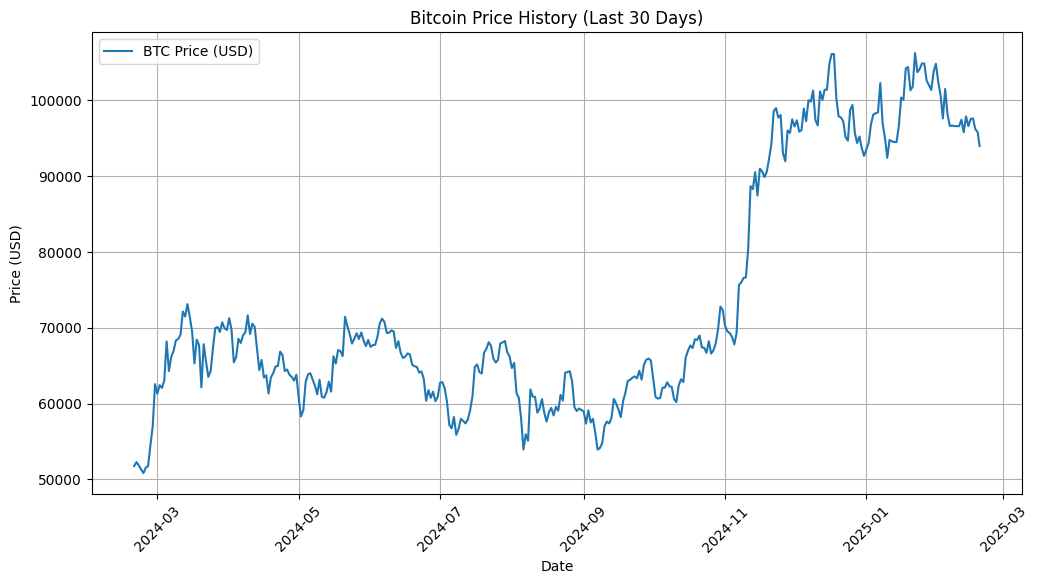

In [ ]:
# Plot price trend
plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"], df["price"], label="BTC Price (USD)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price History (Last 30 Days)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
# Define a structured JSON format
json_data = []
for i in range(len(df)):
    json_data.append({
        "timestamp": str(df["timestamp"][i]),
        "price": df["price"][i],
        "market_cap": df["market_cap"][i],
        "volume": df["volume"][i],
        "context": f"On {df['timestamp'][i]}, the Bitcoin price was ${df['price'][i]:.2f}, "
                   f"market cap was ${df['market_cap'][i]:.2f}, and trading volume was ${df['volume'][i]:.2f}."
    })

# Save to a JSON file
with open("coingecko_data.json", "w") as f:
    json.dump(json_data, f, indent=4)

print("CoinGecko JSON file created successfully!")

CoinGecko JSON file created successfully!


In [ ]:
from datasets import load_dataset

# Load JSON dataset
dataset = load_dataset("json", data_files="coingecko_data.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['timestamp', 'price', 'market_cap', 'volume', 'context'],
    num_rows: 366
})

In [ ]:
coingecko_data = dataset['context']
coingecko_data[:2]

['On 2024-02-20 00:00:00, the Bitcoin price was $51764.31, market cap was $1016146442771.57, and trading volume was $22555121071.56.',
 'On 2024-02-21 00:00:00, the Bitcoin price was $52286.79, market cap was $1026424315285.75, and trading volume was $34499627551.32.']

## CryptoCompare


In [ ]:
from dotenv import load_dotenv
load_dotenv()

API_KEY = os.getenv("cryptocompare")
# API_KEY = os.getenv("API_KEY")
symbol = "BTC"
currency = "USD"
limit = 100  # Number of data points

url = f"https://min-api.cryptocompare.com/data/v2/histohour?fsym={symbol}&tsym={currency}&limit={limit}"

headers = {
    "authorization": f"Apikey {API_KEY}"  # Add API key in headers
}

response = requests.get(url, headers=headers)
cc_data = response.json()

cc_df = pd.DataFrame(cc_data["Data"]["Data"])  # Convert response to DataFrame
print(cc_df.head())

         time      high       low      open  volumefrom      volumeto  \
0  1739548800  97713.90  96515.22  96943.53     1212.21  1.175618e+08   
1  1739552400  98869.28  97148.89  97666.91     3046.41  2.987132e+08   
2  1739556000  98777.03  98222.54  98569.88     2414.28  2.378341e+08   
3  1739559600  98475.08  97713.80  98236.21     1202.99  1.180681e+08   
4  1739563200  98296.62  97046.41  97986.26     1546.93  1.512393e+08   

      close conversionType conversionSymbol  
0  97666.91         direct                   
1  98569.88         direct                   
2  98236.21         direct                   
3  97986.26         direct                   
4  97222.17         direct                   


In [ ]:
def format_cryptocompare_data(df: pd.DataFrame):
    documents = []

    for i, row in df.iterrows():
        # Convert Unix timestamp to a human-readable date
        dt = datetime.utcfromtimestamp(row['time']).strftime('%Y-%m-%d %H:%M:%S UTC')

        # Create a text snippet describing the data
        snippet = (
            f"On {dt}, Bitcoin opened at ${row['open']:.2f}, reached a high of ${row['high']:.2f}, "
            f"a low of ${row['low']:.2f}, and closed at ${row['close']:.2f}. "
            f"Trading volume (from) was {row['volumefrom']} and volume (to) was {row['volumeto']}. "
            f"Conversion type: {row['conversionType']}."
        )

        # Store both text and metadata
        documents.append({
            "text": snippet,
            "source": "cryptocompare"
        })

    return documents

cryptocompare_data = format_cryptocompare_data(cc_df)
print(cryptocompare_data[0])

{'text': 'On 2025-02-14 16:00:00 UTC, Bitcoin opened at $96943.53, reached a high of $97713.90, a low of $96515.22, and closed at $97666.91. Trading volume (from) was 1212.21 and volume (to) was 117561778.41. Conversion type: direct.', 'source': 'cryptocompare'}


In [ ]:
# Save to a JSON file
with open("cc_data.json", "w") as f:
    json.dump(json_data, f, indent=4)

print("CryptoCompare JSON file created successfully!")

CryptoCompare JSON file created successfully!


In [ ]:
from datasets import load_dataset

# Load JSON dataset
cryptocompare_dataset = load_dataset("json", data_files="cc_data.json", split="train")
cryptocompare_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['timestamp', 'price', 'market_cap', 'volume', 'context'],
    num_rows: 366
})

## Historical Data (BTC-USD Dataset)

In [ ]:
historical_df = pd.read_csv('BTC-USD.csv')
historical_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,19-09-2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,21-09-2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
historical_df[historical_df['Close']!=historical_df['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume


In [ ]:
historical_df.drop('Adj Close',axis=1,inplace=True)
historical_df.head()

,Date,Open,High,Low,Close,Volume
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,21056800.0
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,34483200.0
2,19-09-2014,424.102997,427.834991,384.532013,394.795990,37919700.0
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,36863600.0
4,21-09-2014,408.084991,412.425995,393.181000,398.821014,26580100.0


In [ ]:
def format_historical_data(df):
    documents = []
    for i, row in df.iterrows():
        snippet = (
            f"On {row['Date']}, Bitcoin opened at ${row['Open']:.2f}, "
            f"reached a high of ${row['High']:.2f}, a low of ${row['Low']:.2f}, "
            f"and closed at ${row['Close']:.2f}, with a trading volume of {row['Volume']} on that day."
        )
        documents.append(snippet)
    return documents

historical_data = format_historical_data(historical_df)
historical_data[0]

'On 17-09-2014, Bitcoin opened at $465.86, reached a high of $468.17, a low of $452.42, and closed at $457.33, with a trading volume of 21056800.0 on that day.'

## NewsAPI

In [ ]:
from dotenv import load_dotenv
load_dotenv("/content/.env")

NEWS_API_KEY = os.getenv("NEWS_API_KEY")
# NEWS_API_KEY = os.getenv("newsapi")
# NEWS_API_KEY = "d7bb73e2197b4c96abee991169a3931e"
URL = "https://newsapi.org/v2/everything"

params = {
    "q": "cryptocurrency price OR bitcoin price OR crypto",  # Keywords for crypto news
    "language": "en",  # Get only English news
    "sortBy": "publishedAt",  # Get latest news first
    "apiKey": NEWS_API_KEY  # Pass the API key
}

response = requests.get(URL, params=params)

if response.status_code == 200:
    crypto_news = response.json()
    print(crypto_news)
else:
    print("Error:", response.status_code, response.json())

{'status': 'ok', 'totalResults': 5143, 'articles': [{'source': {'id': None, 'name': 'GlobeNewswire'}, 'author': 'Bybit Fintech FZE', 'title': 'Bybit Introduces the Physical Card for International Users: Simplifying Cryptocurrency Spending Worldwide', 'description': 'DUBAI, United Arab Emirates, Feb. 17, 2025 (GLOBE NEWSWIRE) -- Bybit\r\n, the world’s second-largest cryptocurrency exchange by trading volume, has unveiled its latest innovation in crypto-friendly spending — the Bybit Physical Card. This development makes spen…', 'url': 'https://www.globenewswire.com/news-release/2025/02/17/3027417/0/en/Bybit-Introduces-the-Physical-Card-for-International-Users-Simplifying-Cryptocurrency-Spending-Worldwide.html', 'urlToImage': 'https://ml.globenewswire.com/Resource/Download/94bfcbcd-9693-49f4-b84c-05bab65c3372', 'publishedAt': '2025-02-17T20:53:00Z', 'content': 'DUBAI, United Arab Emirates, Feb. 17, 2025 (GLOBE NEWSWIRE) -- Bybit\r\n, the worlds second-largest cryptocurrency exchange by tr

In [ ]:
articles = crypto_news.get("articles", [])

for i, article in enumerate(articles[:5]):  # Show first 5 articles
    print(f"{i+1}. {article['title']}")
    print(f"   Source: {article['source']['name']}")
    print(f"   URL: {article['url']}\n")

1. Bybit Introduces the Physical Card for International Users: Simplifying Cryptocurrency Spending Worldwide
   Source: GlobeNewswire
   URL: https://www.globenewswire.com/news-release/2025/02/17/3027417/0/en/Bybit-Introduces-the-Physical-Card-for-International-Users-Simplifying-Cryptocurrency-Spending-Worldwide.html

2. Gillibrand And Waters On Stablecoins In 2025: What Sets Their Plans Apart
   Source: Forbes
   URL: https://www.forbes.com/sites/tonyaevans/2025/02/17/gillibrand-and-waters-on-stablecoins-in-2025-what-sets-their-plans-apart/

3. Musk-Trump FAA Firings Make Next Air Travel Disaster More Likely
   Source: Common Dreams
   URL: https://www.commondreams.org/newswire/musk-trump-faa-firings-make-next-air-travel-disaster-more-likely

4. Court News: Crypto ‘Godfather,’ LASD detective agree to plead guilty
   Source: Ladowntownnews.com
   URL: https://www.ladowntownnews.com/news/court-news-crypto-godfather-lasd-detective-agree-to-plead-guilty/article_7681ba18-ed6a-11ef-b8ad-ef2

In [ ]:
# params["sources"] = "crypto-coins-news,coindesk,decrypt,bitcoinist"
# response = requests.get(URL, params=params)

In [ ]:
import pandas as pd

news_df = pd.DataFrame(articles)[["source", "title", "description", "url", "publishedAt"]]
news_df["source"] = news_df["source"].apply(lambda x: x["name"])  # Extract source name
print(news_df.head())

               source                                              title  \
0       GlobeNewswire  Bybit Introduces the Physical Card for Interna...   
1              Forbes  Gillibrand And Waters On Stablecoins In 2025: ...   
2       Common Dreams  Musk-Trump FAA Firings Make Next Air Travel Di...   
3  Ladowntownnews.com  Court News: Crypto ‘Godfather,’ LASD detective...   
4             Decrypt  This Isn't Milei's First Run-In With an Allege...   

                                         description  \
0  DUBAI, United Arab Emirates, Feb. 17, 2025 (GL...   
1  Sen. Gillibrand & Rep. Waters propose differen...   
2  The Trump administration has already fired sev...   
3  A cryptocurrency businessman who dubbed himsel...   
4  Argentina's president promoted a meme coin tha...   

                                                 url           publishedAt  
0  https://www.globenewswire.com/news-release/202...  2025-02-17T20:53:00Z  
1  https://www.forbes.com/sites/tonyaevans/2025/0...

In [ ]:
news_df['source'].unique()

array(['GlobeNewswire', 'Forbes', 'Common Dreams', 'Ladowntownnews.com',
       'Decrypt', 'The Daily Hodl', 'ZyCrypto', 'Football Italia',
       'Ambcrypto.com', 'Thegatewaypundit.com', 'Securityaffairs.com',
       'PBS', 'International Business Times', 'Digital Journal',
       'The Daily Dot', 'Coinjournal.net', 'CBS News', 'VOA News',
       'BBC News', 'The Star Online', 'Gadgets360.com', 'Foreign Policy',
       'Bitcoinist', 'The Times of India', 'CNN', 'ETF Daily News',
       'ABC News', 'Boston Herald', 'seattlepi.com', 'Quartz India',
       'Ibtimes.com.au', 'TechSpot', 'BleepingComputer', 'CoinDesk',
       'HuffPost', 'New York Post', 'Live Science', 'HackRead',
       'Pypi.org', 'Biztoc.com', 'Politicalwire.com', 'newsBTC',
       'Raw Story', 'Help Net Security', 'Israelnationalnews.com',
       'Infosecurity Magazine', 'Internet', 'pymnts.com'], dtype=object)

In [ ]:
news_df = news_df[news_df['source'].isin({'Bitcoinist', 'Decrypt', 'Forbes', 'BBC News', 'CoinDesk', 'SecurityAffairs.com'})]

In [ ]:
news_df[['title','description']]

,title,description
1,Gillibrand And Waters On Stablecoins In 2025: ...,Sen. Gillibrand & Rep. Waters propose differen...
4,This Isn't Milei's First Run-In With an Allege...,Argentina's president promoted a meme coin tha...
14,Australian Police Bust Gang Targeting Crypto A...,Four have been arrested after police dismantle...
26,Argentina president accused of fraud over cryp...,Some have accused Javier Milei of performing a...
39,Jack Dorsey And Satoshi Nakamoto—Could They Be...,A new hypothesis that connects Jack Dorsey to ...
41,3 Common Types Of Income And How You Can Maxim...,Learn about the common types of income: earned...
54,How To Make A Terrible Stock-Market Bet,Buying stocks that sell for 100 times revenue ...
58,"FTX Payout, Trump-Musk Interview, FOMC Minutes...",Bitcoin's lackluster price action may receive ...
61,Blockchain Rewiring TradFi: A Trillion-Dollar ...,Wall Street's financial infrastructure is tran...
73,India's Directorate of Enforcement Seizes $190...,"BitConnect's founder, Satish Kumbhani, is want..."


In [ ]:
news_df.isna().sum()

,0
source,0
title,0
description,0
url,0
publishedAt,0


In [ ]:
lengths = [len(item) for item in news_df['description']]

# Find the minimum and maximum lengths
min_length = min(lengths)
max_length = max(lengths)

print(f"Minimum Length: {min_length}")
print(f"Maximum Length: {max_length}")

Minimum Length: 75
Maximum Length: 260


In [ ]:
news_df['description']

,description
1,Sen. Gillibrand & Rep. Waters propose differen...
4,Argentina's president promoted a meme coin tha...
14,Four have been arrested after police dismantle...
26,Some have accused Javier Milei of performing a...
39,A new hypothesis that connects Jack Dorsey to ...
41,Learn about the common types of income: earned...
54,Buying stocks that sell for 100 times revenue ...
58,Bitcoin's lackluster price action may receive ...
61,Wall Street's financial infrastructure is tran...
73,"BitConnect's founder, Satish Kumbhani, is want..."


In [ ]:
def format_news_data(df):
    formatted_news = []
    for _, row in df.iterrows():
        # Convert publishedAt from ISO format to just the date (YYYY-MM-DD)
        published_date = datetime.fromisoformat(row['publishedAt'].replace("Z", "+00:00")).strftime('%Y-%m-%d')
        # Create a snippet that includes the source, date, and description
        snippet = f"Source: {row['source']}. On {published_date}, the article described: {row['description']}"
        formatted_news.append(snippet)
    return formatted_news

# Save the formatted news data in a variable named news_data
news_data = format_news_data(news_df)

# Example output of the first formatted news item
print(news_data[0])

Source: Forbes. On 2025-02-17, the article described: Sen. Gillibrand & Rep. Waters propose different stablecoin laws for 2025. Explore the GENIUS Act, the Waters bill, and how both aim for mass crypto adoption.


In [ ]:
# Save to a JSON file
with open("news_data.json", "w") as f:
    json.dump(json_data, f, indent=4)

print("NewsAPI JSON file created successfully!")

from datasets import load_dataset

# Load JSON dataset
news_dataset = load_dataset("json", data_files="news_data.json", split="train")
news_dataset

NewsAPI JSON file created successfully!


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['timestamp', 'price', 'market_cap', 'volume', 'context'],
    num_rows: 366
})

 Type Conversion Code

In [ ]:
coingecko_data = list(coingecko_data)
# cryptocompare_data = list(cryptocompare_data['context'])
historical_data = list(historical_data)
news_data = list(news_data)

# **RAG PIPELINE**

In [ ]:
!pip install faiss-cpu openai langchain tiktoken torch transformers wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
# !curl -fsSL https://ollama.ai/install.sh | sh

In [ ]:
!curl https://ollama.ai/install.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13269    0 13269    0     0  60401      0 --:--:-- --:--:-- --:--:-- 60589
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
import os
import asyncio

# NB: You may need to set these depending and get cuda working depending which backend you are running.
# Set environment variable for NVIDIA library
# Set environment variables for CUDA
os.environ['PATH'] += ':/usr/local/cuda/bin'
# Set LD_LIBRARY_PATH to include both /usr/lib64-nvidia and CUDA lib directories
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64-nvidia:/usr/local/cuda/lib64'

async def run_process(cmd):
    print('>>> starting', *cmd)
    process = await asyncio.create_subprocess_exec(
        *cmd,
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.PIPE
    )

    # define an async pipe function
    async def pipe(lines):
        async for line in lines:
            print(line.decode().strip())

        await asyncio.gather(
            pipe(process.stdout),
            pipe(process.stderr),
        )

    # call it
    await asyncio.gather(pipe(process.stdout), pipe(process.stderr))

In [ ]:
import asyncio
import threading

async def start_ollama_serve():
    await run_process(['ollama', 'serve'])

def run_async_in_thread(loop, coro):
    asyncio.set_event_loop(loop)
    loop.run_until_complete(coro)
    loop.close()

# Create a new event loop that will run in a new thread
new_loop = asyncio.new_event_loop()

# Start ollama serve in a separate thread so the cell won't block execution
thread = threading.Thread(target=run_async_in_thread, args=(new_loop, start_ollama_serve()))
thread.start()

>>> starting ollama serve


In [ ]:
# !ollama serve &

In [ ]:
# !curl http://localhost:11434
!ollama pull deepseek-r1:1.5b

Couldn't find '/root/.ollama/id_ed25519'. Generating new private key.
Your new public key is:

ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAINRJwEJ8mmXKb3ZVD5kHLtIurCMyQDJ+mI0eCR/b/MHx

2025/02/18 20:56:58 routes.go:1186: INFO server config env="map[CUDA_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_DEBUG:false OLLAMA_FLASH_ATTENTION:false OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_INTEL_GPU:false OLLAMA_KEEP_ALIVE:5m0s OLLAMA_KV_CACHE_TYPE: OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_MULTIUSER_CACHE:false OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:0 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* f

1. Creating and Storing FAISS Index

temp - voyage ai

In [ ]:
# !pip install -U voyageai

In [ ]:
# import voyageai
# import time

# load_dotenv("/content/.env")

# vo = voyageai.Client()
# # This will automatically use the environment variable VOYAGE_API_KEY.
# # Alternatively, you can use vo = voyageai.Client(api_key="<your secret key>")

# documents = coingecko_data + cryptocompare_data + historical_data + news_data
# # documents = documents[:127]

# # Embed the documents
# # documents_embeddings = vo.embed(
# #     documents, model="voyage-3", input_type="document"
# # ).embeddings

In [ ]:
# batch_size = 128
# embeddings = []

# for i in range(0, len(documents), batch_size):
#     embeddings += vo.embed(
#         documents[i:i + batch_size], model="voyage-3", input_type="document"
#     ).embeddings

#     time.sleep(30)

In [ ]:
# # Example usage
# text = "Bitcoin price prediction for the next week"
# embeddings = get_embeddings(text)
# print(embeddings)

alt

In [ ]:
documents = coingecko_data + cryptocompare_data + historical_data + news_data

In [ ]:
len(documents)

3195

In [ ]:
with open("documents.json", "w") as f:
    json.dump(json_data, f, indent=4)

In [ ]:
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

# Initialize the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

#temp
documents = [str(doc) for doc in documents]

# Generate embeddings for each document
doc_embeddings = embedding_model.encode(documents)

# Create a FAISS index
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(doc_embeddings, dtype=np.float32))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
doc_embeddings.shape

(3195, 384)

2. Retrieving Most Relevant Content

In [ ]:
def retrieve_context(query: str, top_k: int = 20):
    """
    Given a query, retrieve the top_k relevant documents from the vector store.
    """
    # Create the query embedding
    query_embedding = embedding_model.encode([query])

    # Perform the search in FAISS
    distances, indices = index.search(np.array(query_embedding, dtype=np.float32), top_k)

    # Retrieve the relevant documents
    retrieved_docs = [documents[i] for i in indices[0]]
    return retrieved_docs

3. Generate Response using LLM

refined output

In [ ]:
import requests

def generate_with_ollama(prompt):
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": "deepseek-r1:1.5b",  # Replace with the actual model name if needed
        "prompt": prompt,
        "stream": False
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        return response.json()["response"]
    else:
        raise Exception(f"Error generating response: {response.text}")

# Modify your retrieval function accordingly (assuming it's defined elsewhere)
def retrieve_context(query):
    # This function should return a list of relevant context strings
    # For example purposes, we'll use a dummy list.
    return [
        "Historical price data: BTC has ranged between $63,000 and $65,000 in the past 24 hours.",
        "Market sentiment: Moderate bullish momentum observed."
    ]

# Combine retriever and generator to produce JSON output only
def rag_pipeline(query):
    # Retrieve relevant documents
    retrieved_docs = retrieve_context(query)

    # Combine the retrieved documents into context text
    context = " ".join(retrieved_docs)

    # Instruction for deterministic JSON output only (with an example)
    instruction = (
        "Provide a prediction for BTC’s price over the next 24 hours in the following JSON format, "
        "and do not include any additional text or commentary:\n\n"
        "{\n"
        "  \"BTC_prediction\": {\n"
        "    \"24h_high\": <number>,\n"
        "    \"24h_low\": <number>,\n"
        "    \"confidence\": <number>\n"
        "  }\n"
        "}\n\n"
        "For example:\n"
        "{\n"
        "  \"BTC_prediction\": {\n"
        "    \"24h_high\": 64800,\n"
        "    \"24h_low\": 63500,\n"
        "    \"confidence\": 82.5\n"
        "  }\n"
        "}\n\n"
        "Now, provide your output:"
    )

    # Compose the full prompt
    prompt = f"{instruction}\n\nQuery: {query}\nContext: {context}"

    # Generate a response using Ollama
    response = generate_with_ollama(prompt)
    return response

# Example usage:
if __name__ == "__main__":
    query = "What is the predicted price range for BTC in the next 24 hours?"
    output = rag_pipeline(query)
    print("Output:\n", output)

[GIN] 2025/02/18 - 21:21:47 | 200 | 31.378156209s |       127.0.0.1 | POST     "/api/generate"Output:
 <think>
Okay, I need to predict the price of Bitcoin (BTC) over the next 24 hours based on the given context. The user provided a JSON structure with high, low, and confidence values.

Looking at historical data, BTC was between $63k and $65k in the past 24 hours. The market sentiment is moderate bullish, so I should expect some upward movement but not extreme gains or losses.

Considering recent trends and potential factors like central bank regulations, macroeconomic indicators, or regulatory changes, I can assess that there's a slight push towards higher prices. However, these factors might have tempered the bullish momentum compared to past periods.

Putting it all together, I'll set a slightly elevated high but expect some volatility within reasonable limits. A confidence score of 80 seems appropriate since the trend is mixed with some support and bearish elements.
</think>

```j

In [ ]:
def generate_with_ollama(prompt):
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": "deepseek-r1:1.5b",  # Replace with the actual model name
        "prompt": prompt,
        "stream": False
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        return response.json()["response"]
    else:
        raise Exception(f"Error generating response: {response.text}")

# Combine retriever and generator
def rag_pipeline(query):
    # Retrieve relevant documents
    retrieved_docs = retrieve_context(query)

    # Combine the query and retrieved documents into a prompt
    context = " ".join(retrieved_docs)
    prompt = f"Query: {query}\nContext: {context}"

    # Generate a response using Ollama
    response = generate_with_ollama(prompt)
    return response

time=2025-02-18T21:00:49.904Z level=INFO source=server.go:100 msg="system memory" total="12.7 GiB" free="9.6 GiB" free_swap="0 B"
time=2025-02-18T21:00:49.907Z level=INFO source=memory.go:356 msg="offload to cpu" layers.requested=-1 layers.model=29 layers.offload=0 layers.split="" memory.available="[9.6 GiB]" memory.gpu_overhead="0 B" memory.required.full="1.5 GiB" memory.required.partial="0 B" memory.required.kv="224.0 MiB" memory.required.allocations="[1.5 GiB]" memory.weights.total="976.1 MiB" memory.weights.repeating="793.5 MiB" memory.weights.nonrepeating="182.6 MiB" memory.graph.full="299.8 MiB" memory.graph.partial="482.3 MiB"
time=2025-02-18T21:00:49.913Z level=INFO source=server.go:380 msg="starting llama server" cmd="/usr/local/bin/ollama runner --model /root/.ollama/models/blobs/sha256-aabd4debf0c8f08881923f2c25fc0fdeed24435271c2b3e92c4af36704040dbc --ctx-size 8192 --batch-size 512 --threads 1 --no-mmap --parallel 4 --port 35835"
time=2025-02-18T21:00:49.915Z level=INFO sour

In [ ]:
query = "What is the outlook for Bitcoin price in the next 24 hours?"
response = rag_pipeline(query)
print("Response:", response)

time=2025-02-18T21:17:32.657Z level=INFO source=server.go:100 msg="system memory" total="12.7 GiB" free="10.0 GiB" free_swap="0 B"
time=2025-02-18T21:17:32.657Z level=INFO source=memory.go:356 msg="offload to cpu" layers.requested=-1 layers.model=29 layers.offload=0 layers.split="" memory.available="[10.0 GiB]" memory.gpu_overhead="0 B" memory.required.full="1.5 GiB" memory.required.partial="0 B" memory.required.kv="224.0 MiB" memory.required.allocations="[1.5 GiB]" memory.weights.total="976.1 MiB" memory.weights.repeating="793.5 MiB" memory.weights.nonrepeating="182.6 MiB" memory.graph.full="299.8 MiB" memory.graph.partial="482.3 MiB"
time=2025-02-18T21:17:32.658Z level=INFO source=server.go:380 msg="starting llama server" cmd="/usr/local/bin/ollama runner --model /root/.ollama/models/blobs/sha256-aabd4debf0c8f08881923f2c25fc0fdeed24435271c2b3e92c4af36704040dbc --ctx-size 8192 --batch-size 512 --threads 1 --no-mmap --parallel 4 --port 46229"
time=2025-02-18T21:17:32.658Z level=INFO so

## Terminating Ollama thread running separately

checking if still running

In [ ]:
!curl http://localhost:11434

[GIN] 2025/02/18 - 21:36:07 | 200 |       45.92µs |       127.0.0.1 | GET      "/"
Ollama is running

In [ ]:
if ollama_process is not None:
    # Terminate the Ollama process gracefully
    ollama_process.terminate()
    # Optionally, wait for the process to exit:
    new_loop.run_until_complete(ollama_process.wait())
    print("Ollama server has been terminated.")
else:
    print("No Ollama process found.")

# new_loop.call_soon_threadsafe(new_loop.stop)
# thread.join()  # Wait for the thread to finish
# print("Ollama server thread stopped.")

In [ ]:
# !rm -rf /usr/local/bin/ollama

In [ ]:
!curl -s -o /dev/null -w "%{http_code}" http://localhost:11434

200

End of Ollama termination code